In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))


        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset("leaf_disease_segmentation/train_images", "leaf_disease_segmentation/train_masks", transform=data_transform)
val_dataset = SegmentationDataset("leaf_disease_segmentation/valid_images", "leaf_disease_segmentation/valid_masks", transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [3]:

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

# for param in model.encoder.parameters():
#     param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:

num_epochs = 50

best_val_loss = float("inf")
model_save_path = "unet_model.pth"

for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}")

        if val_loss < best_val_loss:
            print(f"Validation loss decreased from {best_val_loss:.4f} to {val_loss:.4f}, saving model...")
            torch.save(model.state_dict(), model_save_path)
            best_val_loss = val_loss



Epoch 1/50, Loss: 0.1070622056722641, Validation Loss: 0.0965542636279549
Validation loss decreased from inf to 0.0966, saving model...
Epoch 2/50, Loss: 0.12673550844192505, Validation Loss: 0.11588519838239465
Epoch 3/50, Loss: 0.10278499126434326, Validation Loss: 0.0910344733191388
Validation loss decreased from 0.0966 to 0.0910, saving model...
Epoch 4/50, Loss: 0.09708032011985779, Validation Loss: 0.08654473668762616
Validation loss decreased from 0.0910 to 0.0865, saving model...
Epoch 5/50, Loss: 0.09765498340129852, Validation Loss: 0.08619280571916274
Validation loss decreased from 0.0865 to 0.0862, saving model...
Epoch 6/50, Loss: 0.09700582921504974, Validation Loss: 0.08719187522573131
Epoch 7/50, Loss: 0.10121484845876694, Validation Loss: 0.08701751234808139
Epoch 8/50, Loss: 0.0949491411447525, Validation Loss: 0.0817467040781464
Validation loss decreased from 0.0862 to 0.0817, saving model...
Epoch 9/50, Loss: 0.09710389375686646, Validation Loss: 0.08362355602106877

Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


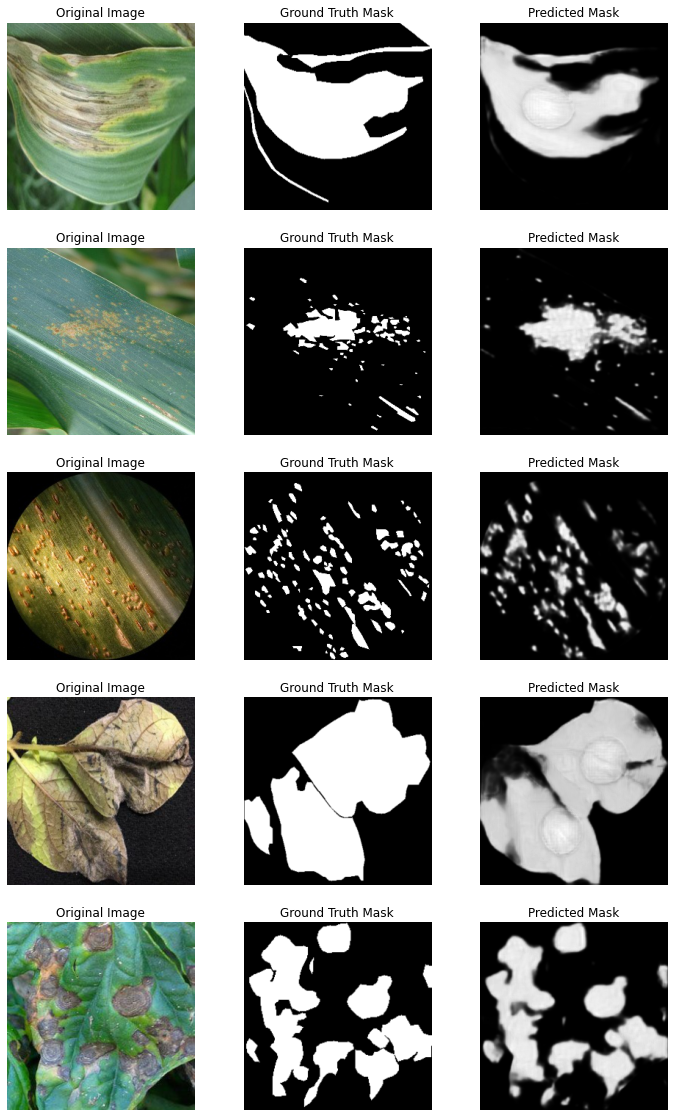

In [5]:


model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
model.eval()


def tensor_to_image(tensor):
    image = tensor.cpu().numpy().transpose((1, 2, 0))
    return (image * 255).astype(np.uint8)

def tensor_to_mask(tensor):
    mask = tensor.cpu().numpy().squeeze()
    return mask

def compute_scores(y_true, y_pred, threshold=0.5):
    y_true = (y_true > threshold).astype(np.uint8).flatten()
    y_pred = (y_pred > threshold).astype(np.uint8).flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

threshold = 0.5

accuracies, precisions, recalls, f1_scores = [], [], [], []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = torch.sigmoid(model(images))
        preds_binary = (preds > threshold).float()

        accuracy, precision, recall, f1 = compute_scores(masks.cpu().numpy(), preds_binary.cpu().numpy())
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    

print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")

num_images_to_plot = min(5, len(images))
fig, ax = plt.subplots(num_images_to_plot, 3, figsize=(12, num_images_to_plot*4))

for i in range(num_images_to_plot):
    ax[i, 0].imshow(tensor_to_image(images[i]))
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(tensor_to_mask(masks[i]), cmap="gray")
    ax[i, 1].set_title("Ground Truth Mask")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(tensor_to_mask(preds[i]), cmap="gray")
    ax[i, 2].set_title("Predicted Mask")
    ax[i, 2].axis("off")

plt.show()